In [1]:
import numpy as np
import pandas as pd

# Set seed for reproducibility
np.random.seed(42)

# Define parameters
n = 100  # number of patients per group
groups = ['Control', 'Treatment A', 'Treatment B']
data = []

# Simulate recovery time (in days) per group
for group in groups:
    if group == 'Control':
        recovery_times = np.random.normal(loc=70, scale=10, size=n)  # avg recovery: 70 days
    elif group == 'Treatment A':
        recovery_times = np.random.normal(loc=65, scale=10, size=n)  # slightly faster
    else:  # Treatment B
        recovery_times = np.random.normal(loc=60, scale=10, size=n)  # fastest

    for rt in recovery_times:
        data.append([group, rt])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Group', 'RecoveryTime'])

# Preview the data
df.head()


,Group,RecoveryTime
0,Control,74.967142
1,Control,68.617357
2,Control,76.476885
3,Control,85.230299
4,Control,67.658466


Vaidating Assumptions by using Shapiro-Wilk Test and Levene’s Test

In [2]:
import scipy.stats as stats

# Shapiro-Wilk Normality Test for each group
print("Shapiro-Wilk Test (Normality):")
for group in df['Group'].unique():
    stat, p = stats.shapiro(df[df['Group'] == group]['RecoveryTime'])
    print(f"{group}: W={stat:.4f}, p-value={p:.4f}")

print("\nLevene's Test (Equal Variance):")
# Levene's Test for homogeneity of variances
stat, p = stats.levene(
    df[df['Group'] == 'Control']['RecoveryTime'],
    df[df['Group'] == 'Treatment A']['RecoveryTime'],
    df[df['Group'] == 'Treatment B']['RecoveryTime']
)
print(f"Levene’s statistic={stat:.4f}, p-value={p:.4f}")


Shapiro-Wilk Test (Normality):
Control: W=0.9899, p-value=0.6552
Treatment A: W=0.9775, p-value=0.0853
Treatment B: W=0.9857, p-value=0.3551

Levene's Test (Equal Variance):
Levene’s statistic=1.2542, p-value=0.2868


One-Way ANOVA + Tukey’s Post-hoc Test

In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# One-Way ANOVA
model = ols('RecoveryTime ~ Group', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA Results:\n")
print(anova_table)

# Post-hoc test: Tukey’s HSD
print("\nTukey’s HSD Test Results:\n")
tukey = pairwise_tukeyhsd(endog=df['RecoveryTime'], groups=df['Group'], alpha=0.05)
print(tukey)


ANOVA Results:

                sum_sq     df          F        PR(>F)
Group      3466.579874    2.0  17.869437  4.698474e-08
Residual  28808.245221  297.0        NaN           NaN

Tukey’s HSD Test Results:

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower    upper  reject
---------------------------------------------------------------
    Control Treatment A  -3.7385 0.0209  -7.0193 -0.4577   True
    Control Treatment B  -8.3126    0.0 -11.5934 -5.0317   True
Treatment A Treatment B  -4.5741 0.0033  -7.8549 -1.2933   True
---------------------------------------------------------------


95% Confidence Intervals for Mean Recovery Time

In [4]:
# Summary stats
summary = df.groupby('Group')['RecoveryTime'].agg(['mean', 'std', 'count'])

# Calculate 95% Confidence Intervals
summary['95% CI'] = 1.96 * (summary['std'] / np.sqrt(summary['count']))
summary['CI Lower'] = summary['mean'] - summary['95% CI']
summary['CI Upper'] = summary['mean'] + summary['95% CI']

summary[['mean', 'std', 'count', 'CI Lower', 'CI Upper']]


,mean,std,count,CI Lower,CI Upper
Group,,,,,
Control,68.961535,9.081684,100,67.181525,70.741545
Treatment A,65.223046,9.536690,100,63.353855,67.092237
Treatment B,60.648963,10.842829,100,58.523768,62.774157


Calculate Effect Size – Cohen’s d

In [5]:
def cohens_d(x1, x2):
    diff = np.mean(x1) - np.mean(x2)
    pooled_std = np.sqrt((np.std(x1, ddof=1) ** 2 + np.std(x2, ddof=1) ** 2) / 2)
    return diff / pooled_std

control = df[df['Group'] == 'Control']['RecoveryTime']
treat_a = df[df['Group'] == 'Treatment A']['RecoveryTime']
treat_b = df[df['Group'] == 'Treatment B']['RecoveryTime']

print("Cohen's d (Control vs Treatment A):", round(cohens_d(control, treat_a), 3))
print("Cohen's d (Control vs Treatment B):", round(cohens_d(control, treat_b), 3))
print("Cohen's d (Treatment A vs Treatment B):", round(cohens_d(treat_a, treat_b), 3))


Cohen's d (Control vs Treatment A): 0.401
Cohen's d (Control vs Treatment B): 0.831
Cohen's d (Treatment A vs Treatment B): 0.448


Visualizing the results




<ipython-input-6-01a865709777>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='RecoveryTime', data=df, palette='pastel')


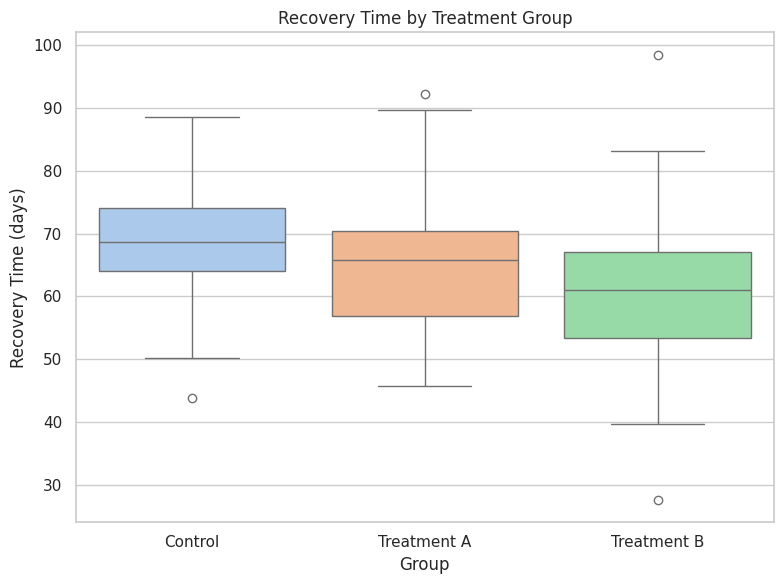

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean theme
sns.set(style="whitegrid")

# Boxplot of Recovery Times by Group
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='RecoveryTime', data=df, palette='pastel')
plt.title('Recovery Time by Treatment Group')
plt.ylabel('Recovery Time (days)')
plt.xlabel('Group')
plt.tight_layout()
plt.show()


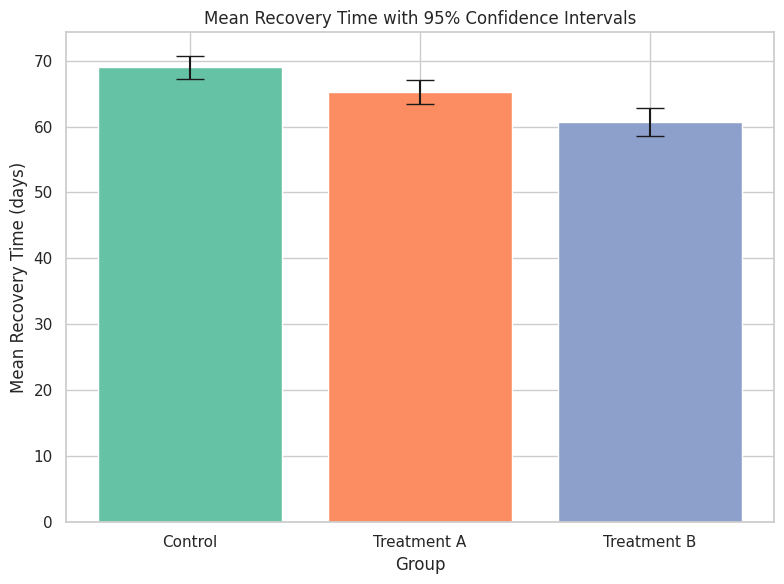

In [9]:
# Reset index to make 'Group' a column
summary_plot = summary.reset_index()

plt.figure(figsize=(8, 6))

# Bar plot using matplotlib directly (avoids seaborn's error with yerr)
plt.bar(
    summary_plot['Group'],
    summary_plot['mean'],
    yerr=summary_plot['95% CI'],
    capsize=10,
    color=['#66c2a5', '#fc8d62', '#8da0cb']
)

plt.title('Mean Recovery Time with 95% Confidence Intervals')
plt.ylabel('Mean Recovery Time (days)')
plt.xlabel('Group')
plt.tight_layout()
plt.show()

